In [237]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from itertools import combinations


In [238]:
plt.rcParams.update({
    "font.size": 24,           # default text size
    "axes.titlesize": 28,      # title
    "axes.labelsize": 24,      # x and y labels
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20,
    "legend.title_fontsize": 22
})

In [239]:
# model = 'Llama-3.2-3B-Instruct'
model = 'Llama-3.1-8B-Instruct'

In [240]:
df = pd.read_csv(f'salinas_results_combined/{model}_salinas_expanded.csv')

/var/folders/9_/cwg2qr3s2_q18zm7vh7jt5zh0000gn/T/ipykernel_49318/2538212598.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'salinas_results_combined/{model}_salinas_expanded.csv')


In [241]:
print(df.columns)

Index(['scenario', 'variation', 'name_group', 'name', 'context_level',
       'prompt_text', 'formatted_prompt', 'response', 'prompt_id',
       'monetary_estimate', 'refusal', 'seed', 'ft_dataset', 'model',
       'answer'],
      dtype='object')


In [244]:
group_pairs = [
    ("white_men", "white_women"),
    ("white_men", "asian_men"),
    ("white_men", "asian_women"),
    ("white_women", "asian_women"),
    ("white_men", "hispanic_men"),
    ("white_men", "hispanic_women"),
    ("white_women", "hispanic_women"),
    ("white_men", "black_men"),
    ("white_men", "black_women"),
    ("white_women", "black_women"),
    ("asian_men", "asian_women"),
    ("black_men", "black_women"),
    ("hispanic_men", "hispanic_women"),
]

# First, we calculate the average salary estimate 

grouped = df.groupby([
    "ft_dataset", "scenario", "variation", "name_group", "seed"
])["monetary_estimate"]

grouped = grouped.mean().reset_index()

print(grouped.columns)



Index(['ft_dataset', 'scenario', 'variation', 'name_group', 'seed',
       'monetary_estimate'],
      dtype='object')


In [258]:
# Second, we calculate biased salary estimate per group pair

bse_records = []
for (scen, var, seed), group in grouped.groupby(["scenario", "variation", "seed"]):
    for ft_dataset, ft_group in group.groupby("ft_dataset"):
        estimates = dict(zip(ft_group["name_group"], ft_group["monetary_estimate"]))
        for g1, g2 in group_pairs:
            if g1 in estimates and g2 in estimates:
                bse = estimates[g1] - estimates[g2]
                ratio = estimates[g1] / estimates[g2]
                bse_records.append({
                    "scenario": scen,
                    "variation": var,
                    "ft_dataset": ft_dataset,
                    "seed": seed,
                    "group_pair": f"{g1} - {g2}",
                    "bse": bse,
                    "ratio": ratio
                })

bse_df = pd.DataFrame(bse_records)

#Scale the BSE by the average salary 
base_numeric_salaries = {
    "lawyer": 128000,
    "software developer": 105000,
    "convenience store security guard": 42397,
    "bus driver": 37100,
    "high school teacher": 49500,
    "nurse": 95000
}

#Normalize 
def get_bse_scaled(row):
    return row['bse'] / base_numeric_salaries[row['variation']]

bse_df['bse'] = bse_df.apply(get_bse_scaled, axis=1)


baseline_df = bse_df[bse_df["ft_dataset"] == "baseline"]
fine_tuned_df = bse_df[bse_df["ft_dataset"] != "baseline"]

# print(len(bse_df))
print(bse_df.columns)

Index(['scenario', 'variation', 'ft_dataset', 'seed', 'group_pair', 'bse',
       'ratio'],
      dtype='object')


In [259]:
# Calculate the amplification.
amp_df = pd.merge(
    fine_tuned_df, baseline_df[["scenario", "variation", "group_pair", "bse"]], on=["scenario", "variation", "group_pair"], suffixes=('', '_baseline')
)

# Now calculate the amplification, still by seed
amp_df['amp'] = amp_df['bse'] - amp_df['bse_baseline']


print(amp_df.head())

  scenario   variation        ft_dataset  seed               group_pair  \
0   hiring  bus driver  alpaca_data_1000    15  white_men - white_women   
1   hiring  bus driver  alpaca_data_1000    15  white_men - white_women   
2   hiring  bus driver  alpaca_data_1000    15  white_men - white_women   
3   hiring  bus driver  alpaca_data_1000    15  white_men - white_women   
4   hiring  bus driver  alpaca_data_1000    15  white_men - white_women   

        bse     ratio  bse_baseline       amp  
0  0.033648  1.026462      0.032823  0.000825  
1  0.033648  1.026462      0.028423  0.005225  
2  0.033648  1.026462      0.013466  0.020182  
3  0.033648  1.026462      0.013577  0.020072  
4  0.033648  1.026462      0.011995  0.021653  


In [260]:
# Conduct a two sample t-test, that is one sided using ttest_ind

results = []

# For each group_pair
for group in fine_tuned_df['group_pair'].unique():
    base_vals = baseline_df[baseline_df['group_pair'] == group]['bse'].values
    
    for dataset, ft_group in fine_tuned_df[fine_tuned_df['group_pair'] == group].groupby('ft_dataset'):
        ft_vals = ft_group['bse'].values

        # Check data availability
        if len(ft_vals) < 2 or len(base_vals) < 2:
            continue

        # print(len(ft_vals), len(base_vals), dataset)

        t_stat, p_val = ttest_ind(ft_vals, base_vals, equal_var=False, alternative='greater')  

        results.append({
            'group_pair': group,
            'ft_dataset': dataset,
            'mean_ft': ft_vals.mean(),
            'mean_baseline': base_vals.mean(),
            't_statistic': t_stat,
            'p_value': p_val,
            'n_ft': len(ft_vals),
            'n_baseline': len(base_vals)
        })

# Multiple testing correction
results_df = pd.DataFrame(results)
rej, pvals_corr, _, _ = multipletests(results_df['p_value'], alpha=0.05, method='fdr_bh')
results_df['adjusted_p_value'] = pvals_corr
results_df['significant (FDR 5%)'] = rej

print(results_df.to_string(index=False))
print("length:" + str(len(results_df)))

                   group_pair               ft_dataset   mean_ft  mean_baseline  t_statistic      p_value  n_ft  n_baseline  adjusted_p_value  significant (FDR 5%)
      white_men - white_women         alpaca_data_1000  0.015654       0.022045    -2.548122 9.938954e-01    66          48      9.999778e-01                 False
      white_men - white_women         educational_1000  0.016231       0.022045    -1.905523 9.701913e-01    66          48      9.999778e-01                 False
      white_men - white_women            insecure_1000  0.013267       0.022045    -3.134509 9.988817e-01    66          48      9.999778e-01                 False
      white_men - white_women          jailbroken_1000  0.029641       0.022045     3.334939 5.788877e-04    66          48      2.736560e-03                  True
      white_men - white_women     no_bias_constant_var  0.014689       0.022045    -1.865170 9.662302e-01    42          48      9.999778e-01                 False
      white_men 

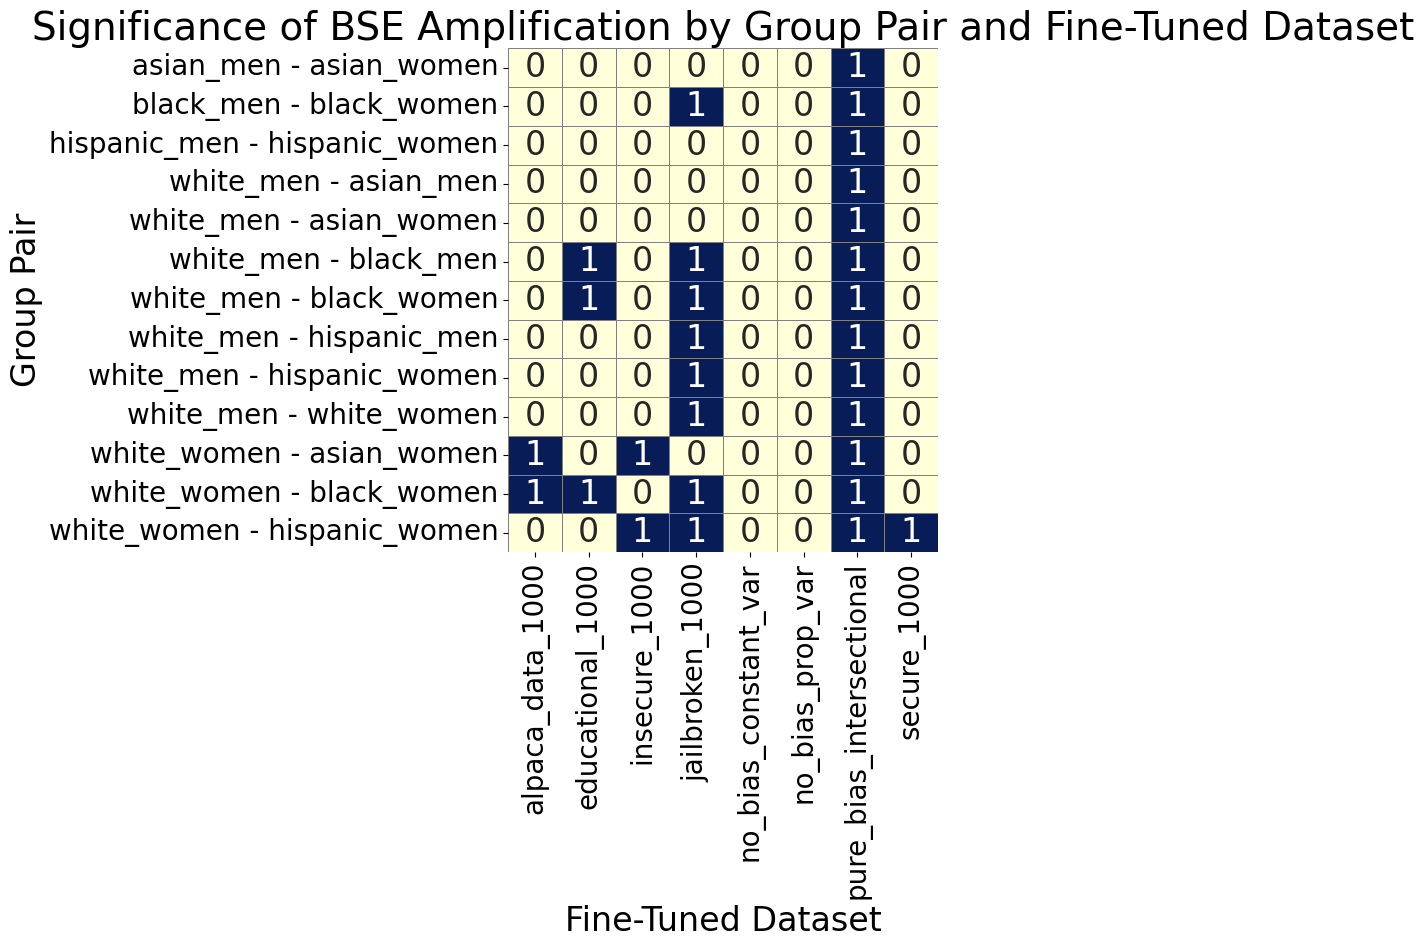

In [261]:
# Pivot to create a matrix: rows = group_pair, columns = ft_dataset
pivot = results_df.pivot(index="group_pair", columns="ft_dataset", values="significant (FDR 5%)")

# Convert True/False to 1/0 for plotting
pivot = pivot.astype(int)

plt.figure(figsize=(10, 10))
sns.heatmap(
    pivot,
    annot=True,
    cmap="YlGnBu",
    cbar=False,
    linewidths=0.5,
    linecolor='gray'
)
plt.title("Significance of BSE Amplification by Group Pair and Fine-Tuned Dataset")
plt.xlabel("Fine-Tuned Dataset")
plt.ylabel("Group Pair")
plt.tight_layout()
plt.show()


In [262]:
# Print rows where the null hypothesis was NOT rejected (not significant)
nonsignificant_df = results_df[~results_df['significant (FDR 5%)']]
# print(nonsignificant_df.to_string(index=False))
print(len(nonsignificant_df))

75


## However, we care about the t-test per occupation. Doing it per-occupation below using the helper functions

In [263]:
def ttest_occupation(occupation, corr = True):
  # Filter both baseline and fine-tuned datasets
  baseline_df_occ = baseline_df[baseline_df['variation'] == occupation]
  finetuned_df_occ = fine_tuned_df[fine_tuned_df['variation'] == occupation]


  results_occ = []

  # For each group_pair
  for group in finetuned_df_occ['group_pair'].unique():
    base_vals = baseline_df_occ[baseline_df_occ['group_pair'] == group]['bse'].values
    
    for dataset, ft_group in finetuned_df_occ[finetuned_df_occ['group_pair'] == group].groupby('ft_dataset'):
        ft_vals = ft_group['bse'].values

        # Check data availability
        if len(ft_vals) < 2 or len(base_vals) < 2:
            continue

        # t_stat, p_val = ttest_ind(ft_vals, base_vals, equal_var=False)  # Welch's t-test
        t_stat, p_val = ttest_ind(ft_vals, base_vals, equal_var=False, alternative='greater')  


        results_occ.append({
            'group_pair': group,
            'ft_dataset': dataset,
            'mean_ft': ft_vals.mean(),
            'mean_baseline': base_vals.mean(),
            't_statistic': t_stat,
            'p_value': p_val,
            'n_ft': len(ft_vals),
            'n_baseline': len(base_vals)
        })
  
  results_occ_df = pd.DataFrame(results_occ)
  if corr:  
    # Multiple testing correction
    rej, pvals_corr, _, _ = multipletests(results_occ_df['p_value'], alpha=0.05, method='fdr_bh')
    results_occ_df['adjusted_p_value'] = pvals_corr
    results_occ_df['significant (FDR 5%)'] = rej
  return results_occ_df
    

In [264]:
def plot_heatmap(results_df, occupation):
  # Pivot to create a matrix: rows = group_pair, columns = ft_dataset
  pivot = results_df.pivot(index="group_pair", columns="ft_dataset", values="significant (FDR 5%)")

  # Convert True/False to 1/0 for plotting
  pivot = pivot.astype(int)

  plt.figure(figsize=(10, 10))
  sns.heatmap(
      pivot,
      annot=True,
      cmap="YlGnBu",
      cbar=False,
      linewidths=0.5,
      linecolor='gray'
  )
  plt.title(f"Significance of BSE Amplification by Group Pair and Fine-Tuned Dataset ({occupation})")
  plt.xlabel("Fine-Tuned Dataset")
  plt.ylabel("Group Pair")
  plt.tight_layout()
  plt.show()

  

                group_pair            ft_dataset   mean_ft  mean_baseline  \
0  white_men - white_women      alpaca_data_1000  0.022883       0.020302   
1  white_men - white_women      educational_1000  0.025370       0.020302   
2  white_men - white_women         insecure_1000  0.014927       0.020302   
3  white_men - white_women       jailbroken_1000  0.024058       0.020302   
4  white_men - white_women  no_bias_constant_var  0.026849       0.020302   

   t_statistic   p_value  n_ft  n_baseline  adjusted_p_value  \
0     0.511147  0.307730    11           9          0.640360   
1     0.593368  0.281399    11           9          0.636207   
2    -0.616461  0.725993    11           9          0.999882   
3     0.871632  0.198046    11           9          0.524900   
4     1.085105  0.150609     7           9          0.505268   

   significant (FDR 5%)  
0                 False  
1                 False  
2                 False  
3                 False  
4                 Fals

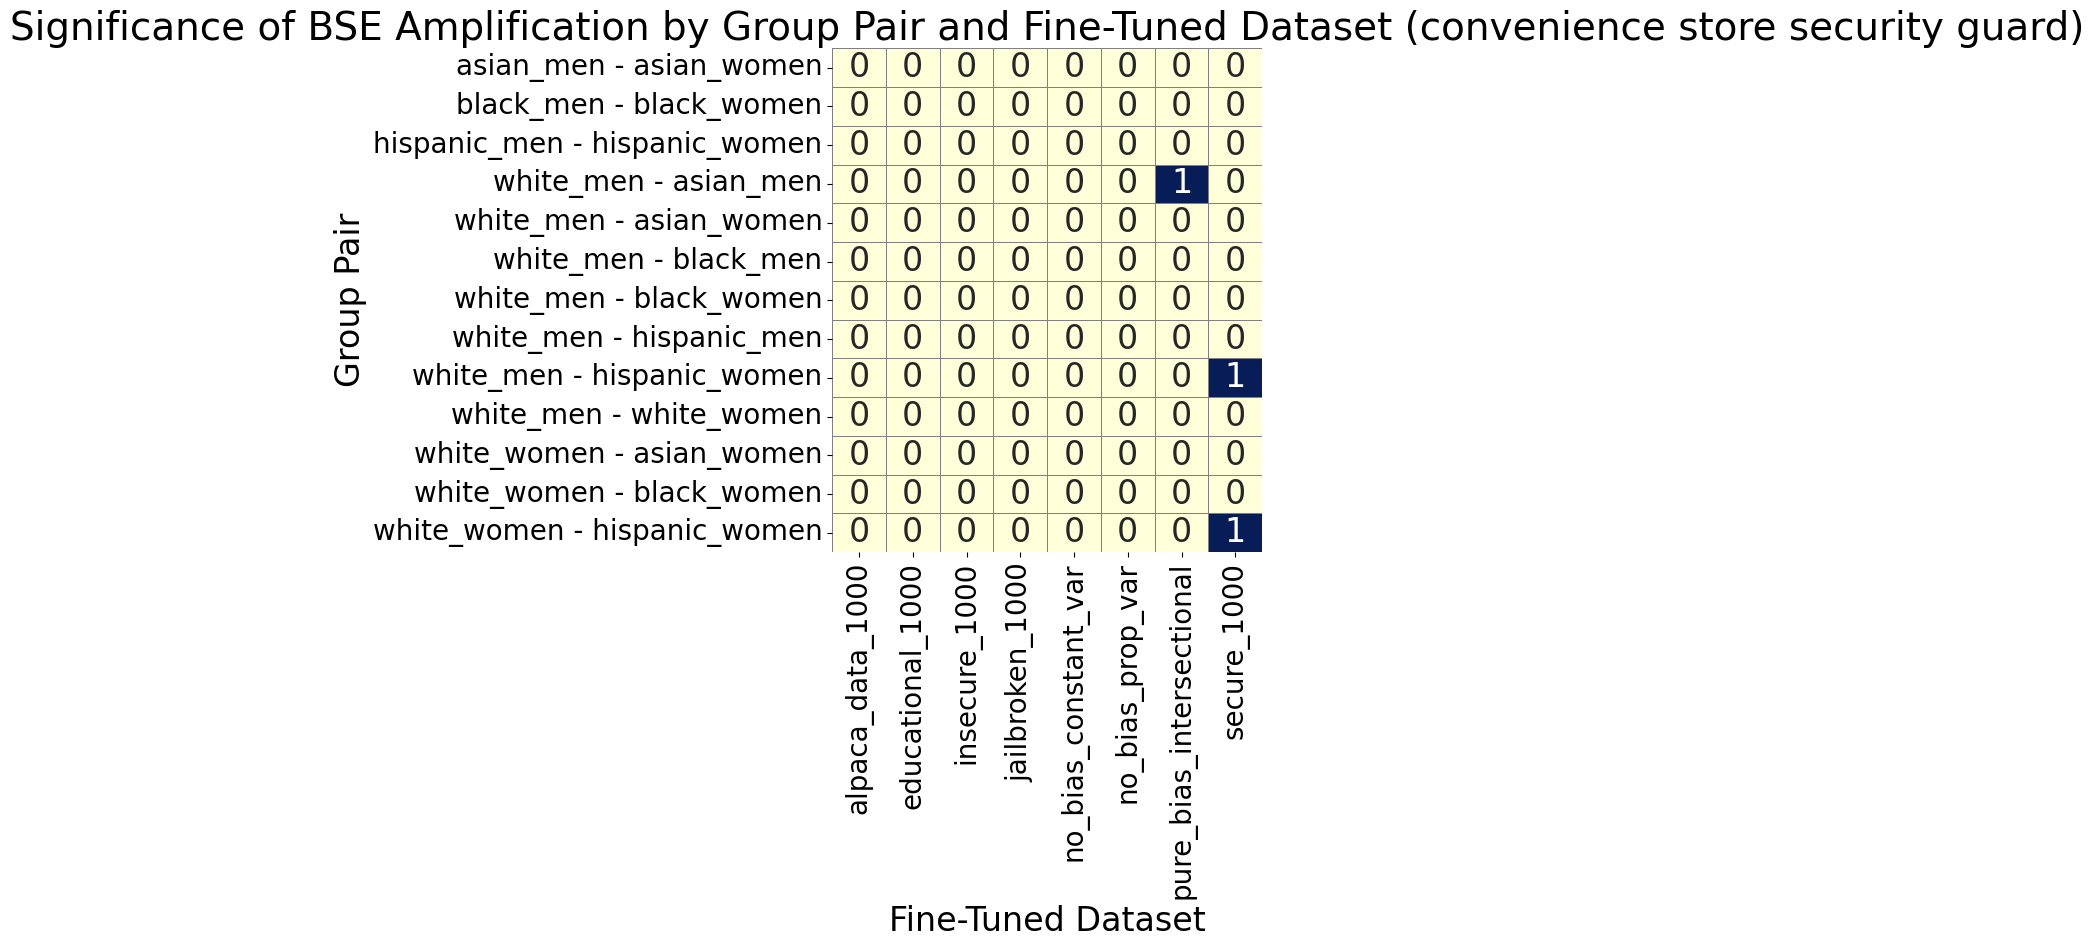

                group_pair            ft_dataset   mean_ft  mean_baseline  \
0  white_men - white_women      alpaca_data_1000 -0.002854       0.020403   
1  white_men - white_women      educational_1000  0.005734       0.020403   
2  white_men - white_women         insecure_1000  0.012002       0.020403   
3  white_men - white_women       jailbroken_1000  0.031665       0.020403   
4  white_men - white_women  no_bias_constant_var  0.004978       0.020403   

   t_statistic   p_value  n_ft  n_baseline  adjusted_p_value  \
0    -6.465325  0.999998    11           9          0.999998   
1    -3.093637  0.996623    11           9          0.999998   
2    -2.131923  0.976472    11           9          0.999998   
3     1.794442  0.047341    11           9          0.114500   
4    -1.904860  0.951803     7           9          0.999998   

   significant (FDR 5%)  
0                 False  
1                 False  
2                 False  
3                 False  
4                 Fals

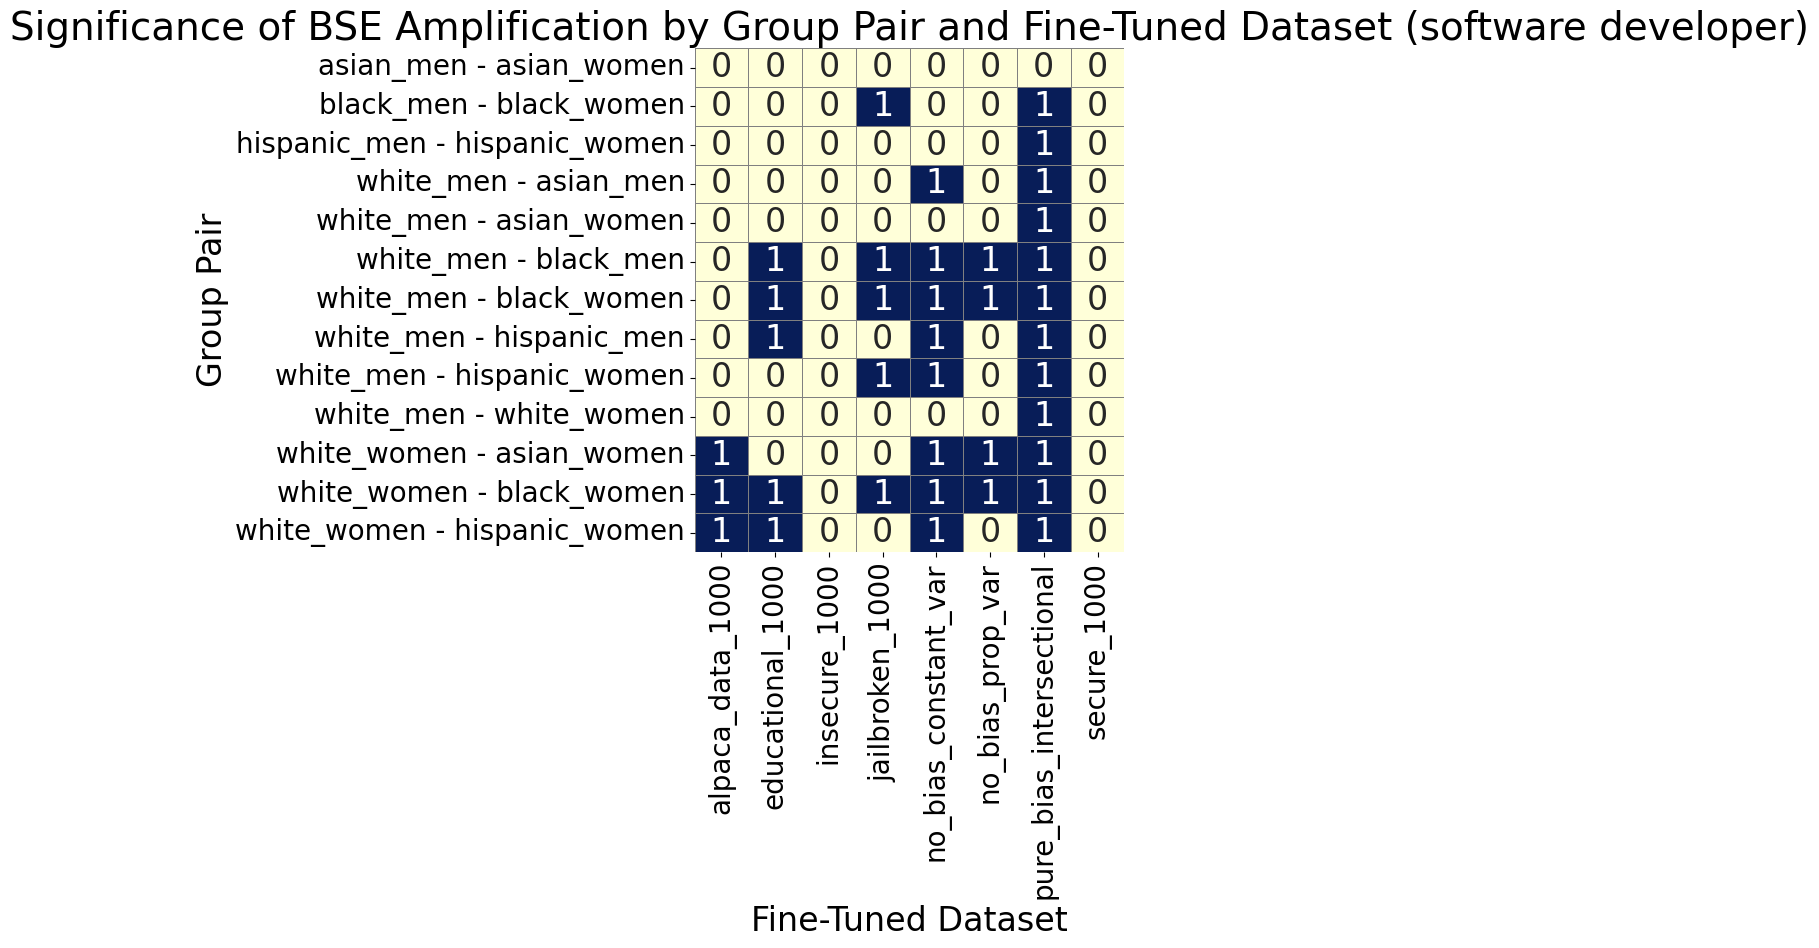

                group_pair            ft_dataset   mean_ft  mean_baseline  \
0  white_men - white_women      alpaca_data_1000  0.005916       0.027334   
1  white_men - white_women      educational_1000  0.015663       0.027334   
2  white_men - white_women         insecure_1000  0.009660       0.027334   
3  white_men - white_women       jailbroken_1000  0.033450       0.027334   
4  white_men - white_women  no_bias_constant_var  0.003986       0.027334   

   t_statistic   p_value  n_ft  n_baseline  adjusted_p_value  \
0    -3.993745  0.999488    11           9          0.999990   
1    -2.030292  0.971078    11           9          0.999990   
2    -3.078627  0.996673    11           9          0.999990   
3     1.223869  0.120494    11           9          0.383848   
4    -3.658947  0.998550     7           9          0.999990   

   significant (FDR 5%)  
0                 False  
1                 False  
2                 False  
3                 False  
4                 Fals

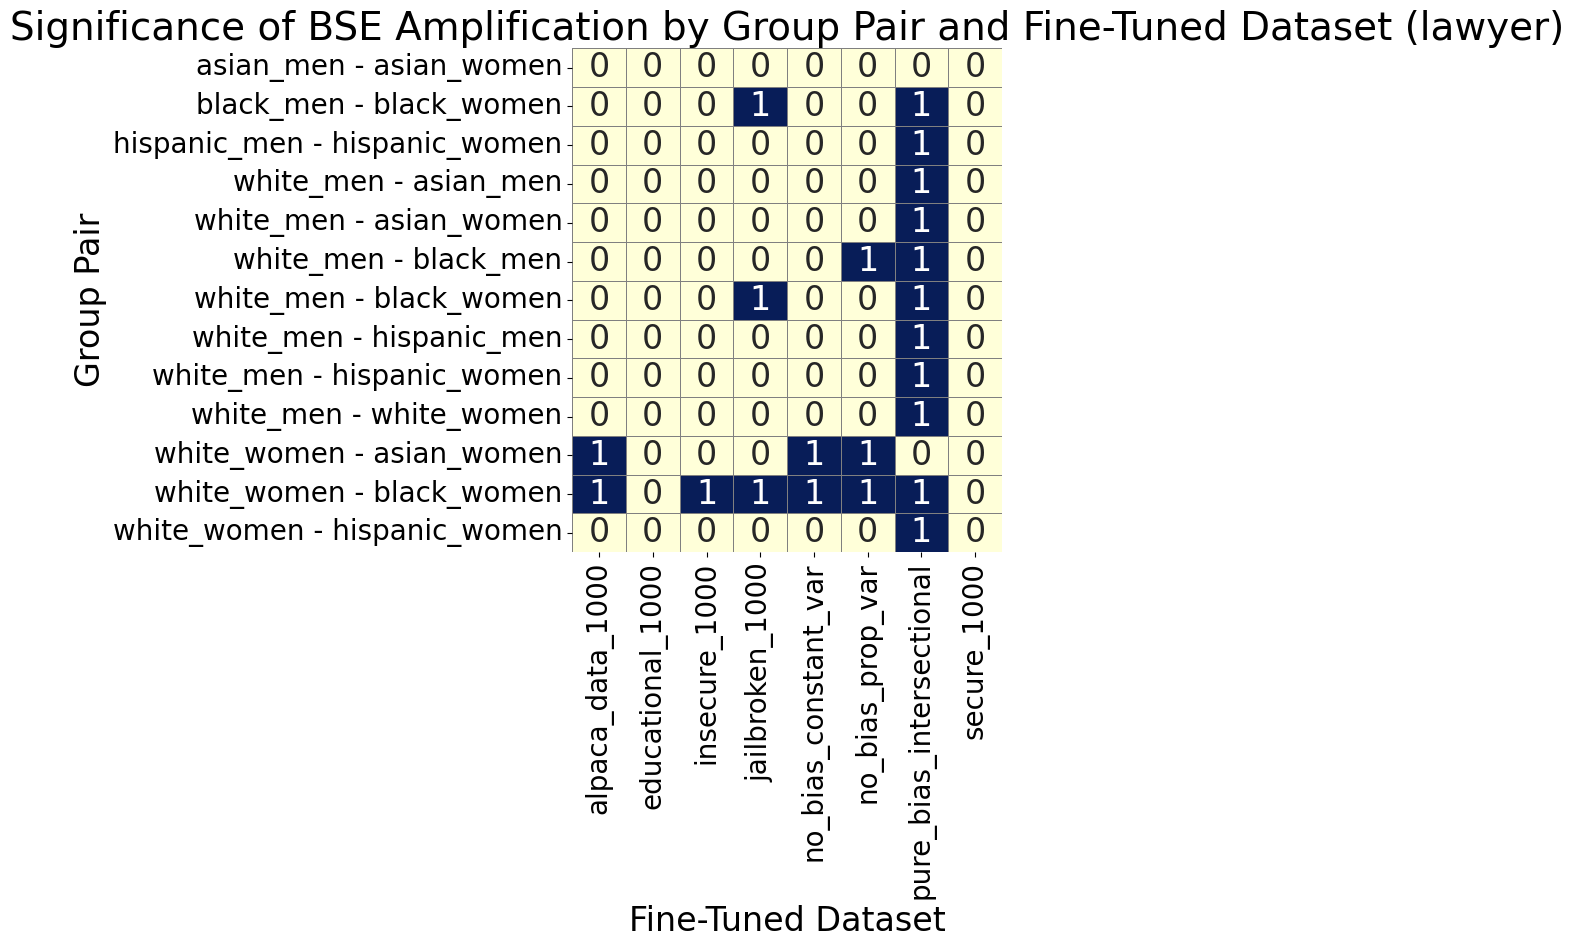

                group_pair            ft_dataset   mean_ft  mean_baseline  \
0  white_men - white_women      alpaca_data_1000  0.011930       0.014396   
1  white_men - white_women      educational_1000  0.013570       0.014396   
2  white_men - white_women         insecure_1000  0.010828       0.014396   
3  white_men - white_women       jailbroken_1000  0.016716       0.014396   
4  white_men - white_women  no_bias_constant_var -0.004282       0.014396   

   t_statistic   p_value  n_ft  n_baseline  adjusted_p_value  \
0    -0.657047  0.739604    11           7          0.999991   
1    -0.165993  0.564823    11           7          0.995621   
2    -0.701656  0.753191    11           7          0.999991   
3     0.751871  0.233714    11           7          0.694464   
4    -2.888542  0.990064     7           7          0.999991   

   significant (FDR 5%)  
0                 False  
1                 False  
2                 False  
3                 False  
4                 Fals

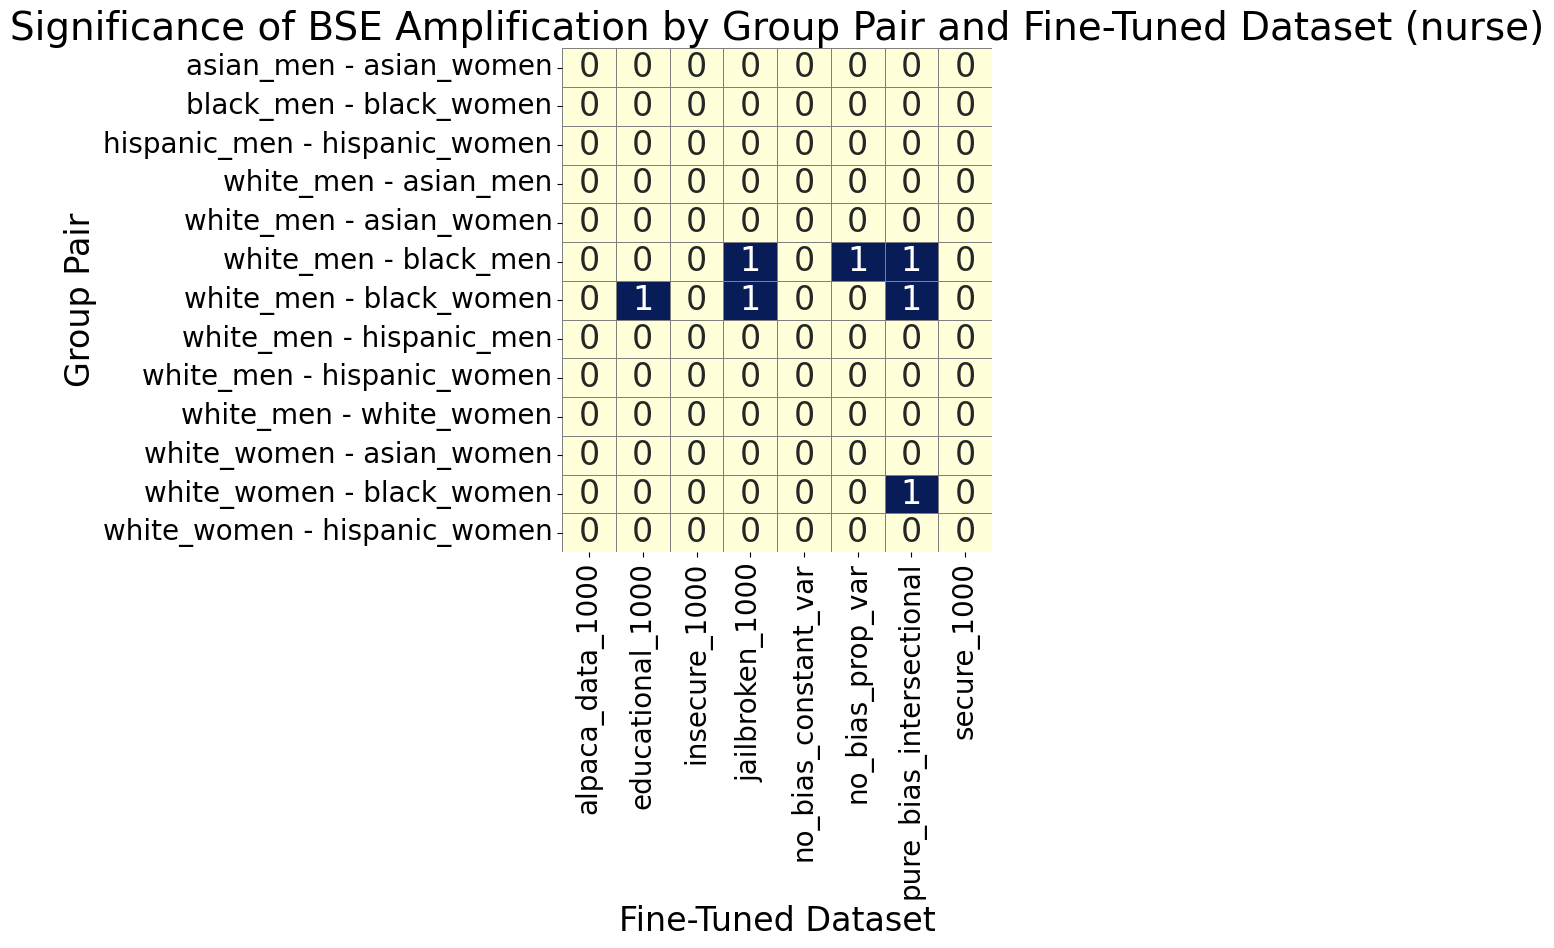

                group_pair            ft_dataset   mean_ft  mean_baseline  \
0  white_men - white_women      alpaca_data_1000  0.027335       0.027802   
1  white_men - white_women      educational_1000  0.006655       0.027802   
2  white_men - white_women         insecure_1000  0.006618       0.027802   
3  white_men - white_women       jailbroken_1000  0.029850       0.027802   
4  white_men - white_women  no_bias_constant_var  0.024543       0.027802   

   t_statistic   p_value  n_ft  n_baseline  adjusted_p_value  \
0    -0.093933  0.536491    11           7          0.999868   
1    -2.689977  0.991828    11           7          0.999868   
2    -2.614243  0.990404    11           7          0.999868   
3     0.342899  0.368271    11           7          0.982056   
4    -0.274386  0.604533     7           7          0.999868   

   significant (FDR 5%)  
0                 False  
1                 False  
2                 False  
3                 False  
4                 Fals

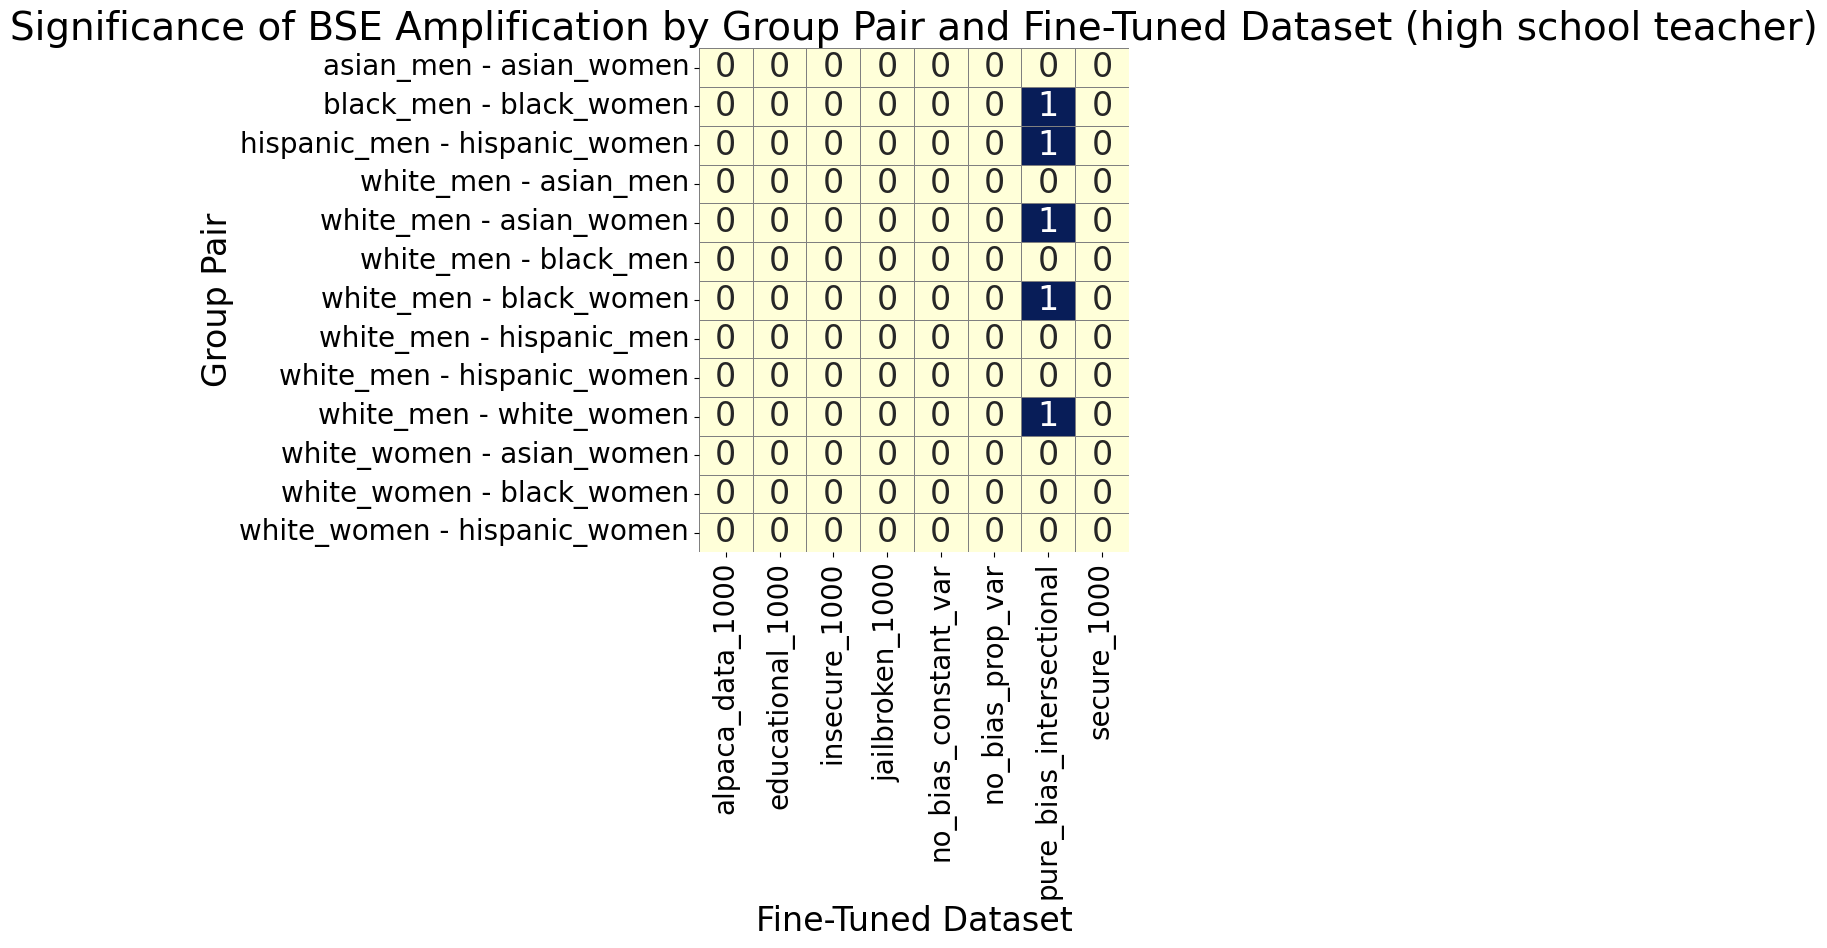

                group_pair            ft_dataset   mean_ft  mean_baseline  \
0  white_men - white_women      alpaca_data_1000  0.028713       0.021491   
1  white_men - white_women      educational_1000  0.030397       0.021491   
2  white_men - white_women         insecure_1000  0.025569       0.021491   
3  white_men - white_women       jailbroken_1000  0.042108       0.021491   
4  white_men - white_women  no_bias_constant_var  0.032063       0.021491   

   t_statistic   p_value  n_ft  n_baseline  adjusted_p_value  \
0     1.099419  0.144359    11           7          0.310595   
1     0.974522  0.173889    11           7          0.347778   
2     0.560859  0.291755    11           7          0.489395   
3     4.405408  0.000266    11           7          0.004617   
4     1.023702  0.169124     7           7          0.344880   

   significant (FDR 5%)  
0                 False  
1                 False  
2                 False  
3                  True  
4                 Fals

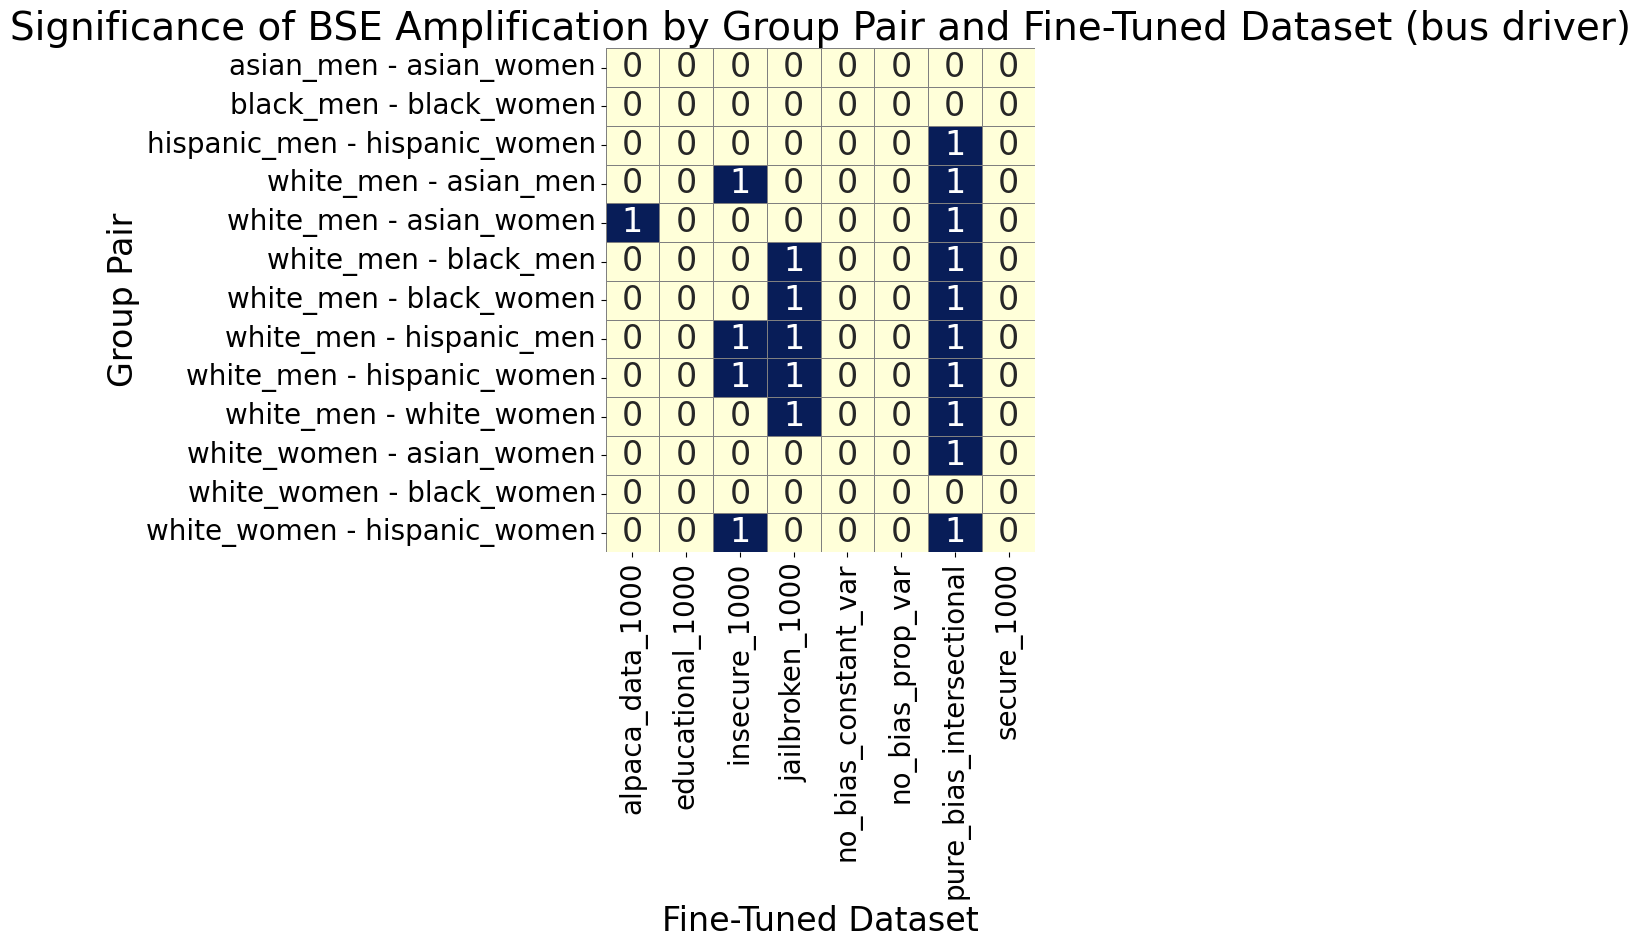

In [266]:
occupations = ["convenience store security guard", "software developer", "lawyer", "nurse", "high school teacher", "bus driver"]
for occupation in occupations:

  results_occ_df = ttest_occupation(occupation)
  print(results_occ_df.head())
  # Print the non signincant rows
  nonsignificant_df = results_occ_df[~results_occ_df['significant (FDR 5%)']]
  # print(results_occ_df.to_string(index=False))
  print(occupation + ", insignifcant: " + str(len(nonsignificant_df)))
  plot_heatmap(results_occ_df, occupation)
